### Installations

In [1]:
%pip install pandas numpy scikit-learn matplotlib seaborn great-tables matplotlib-venn

Note: you may need to restart the kernel to use updated packages.


### Fig 3a | Reliability of PARK Predictions Compared to PD Specialists

In [2]:
import sys
import pandas as pd
import numpy as np
from great_tables import GT, style, loc
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [3]:
df = pd.read_csv('../../data/test_data_big.csv')

df = df.dropna(subset=['neurologist_label_ray', 'neurologist_label_ruth', 'neurologist_label_jamie'])
assert len(df) == 30, f"Expected 30 rows, but got {len(df)}"

true_labels = df['true_label'].astype(int)

predictions = {
    "Specialist 1": df['neurologist_label_ray'].astype(int),
    "Specialist 2": df['neurologist_label_ruth'].astype(int),
    "Specialist 3": df['neurologist_label_jamie'].astype(int),
    "PARK": (df['pred_score_fusion'] >= 0.5).astype(int)
}


def bootstrap_metrics(y_true, y_pred, b=1000):
    n = len(y_true)
    metrics = {
        "accuracy": [],
        "specificity": [],
        "sensitivity": [],
        "ppv": [],
        "npv": [],
        "f1_score": []
    }
    
    for j in range(b):
        idxs = np.random.choice(n, n, replace=True)
        y_true_sample = y_true.iloc[idxs]
        y_pred_sample = y_pred.iloc[idxs]

        if(np.sum(np.asarray(y_true_sample))==0 or np.sum(~np.asarray(y_true_sample))==0 or np.sum(np.asarray(y_pred_sample))==0 or np.sum(~np.asarray(y_pred_sample))==0):
            print(y_true_sample)
            print(y_pred_sample)
            j = j-1
            continue
            
        tn, fp, fn, tp = confusion_matrix(y_true_sample, y_pred_sample, labels=[0,1]).ravel()
        
        acc = accuracy_score(y_true_sample, y_pred_sample)
        sens = recall_score(y_true_sample, y_pred_sample)
        spec = tn / (tn + fp) if (tn + fp) != 0 else 0
        ppv_val = precision_score(y_true_sample, y_pred_sample)
        npv_val = tn / (tn + fn) if (tn + fn) != 0 else 0
        f1 = f1_score(y_true_sample, y_pred_sample)
        
        metrics["accuracy"].append(acc)
        metrics["specificity"].append(spec)
        metrics["sensitivity"].append(sens)
        metrics["ppv"].append(ppv_val)
        metrics["npv"].append(npv_val)
        metrics["f1_score"].append(f1)
    
    results = {}
    for key in metrics.keys():
        mean = np.mean(metrics[key])
        std = np.std(metrics[key], ddof=1)
        ci = 1.96 * std
        results[key] = (mean, ci)
    
    return results


model_results = {}
for model_name, preds in predictions.items():
    model_results[model_name] = bootstrap_metrics(true_labels, preds)

data = {
    "Model": [],
    "Accuracy": [],
    "Specificity": [],
    "Sensitivity": [],
    "PPV": [],
    "NPV": [],
    "F1 Score": []
}

for model_name, results in model_results.items():
    data["Model"].append(model_name)
    data["Accuracy"].append(f"{results['accuracy'][0]*100:.1f}% ±{results['accuracy'][1]*100:.1f}%")
    data["Specificity"].append(f"{results['specificity'][0]*100:.1f}% ±{results['specificity'][1]*100:.1f}%")
    data["Sensitivity"].append(f"{results['sensitivity'][0]*100:.1f}% ±{results['sensitivity'][1]*100:.1f}%")
    data["PPV"].append(f"{results['ppv'][0]*100:.1f}% ±{results['ppv'][1]*100:.1f}%")
    data["NPV"].append(f"{results['npv'][0]*100:.1f}% ±{results['npv'][1]*100:.1f}%")
    data["F1 Score"].append(f"{results['f1_score'][0]*100:.1f}% ±{results['f1_score'][1]*100:.1f}%")

df_metrics = pd.DataFrame(data)

In [4]:
df_metrics

,Model,Accuracy,Specificity,Sensitivity,PPV,NPV,F1 Score
0,Specialist 1,80.2% ±14.1%,38.2% ±34.6%,95.7% ±8.8%,80.8% ±15.1%,76.0% ±48.4%,87.4% ±10.1%
1,Specialist 2,86.7% ±12.2%,62.8% ±36.7%,95.5% ±8.5%,87.6% ±13.4%,83.4% ±33.0%,91.2% ±8.6%
2,Specialist 3,76.7% ±15.9%,75.5% ±32.9%,77.1% ±18.0%,89.5% ±14.5%,54.7% ±29.5%,82.5% ±13.5%
3,PARK,83.7% ±14.1%,74.6% ±33.9%,87.0% ±14.4%,90.6% ±12.9%,67.4% ±33.4%,88.5% ±10.7%


In [5]:
def split_metric_ci(value):
    metric, ci = value.split(' ')
    return f"{metric}<br>{ci}"

metric_columns = ["Accuracy", "Specificity", "Sensitivity", "PPV", "NPV", "F1 Score"]
for col in metric_columns:
    df_metrics[col] = df_metrics[col].apply(split_metric_ci)


In [6]:
gt = GT(df_metrics)

palette = [
    (255, 255, 255),  # white
    (0, 180, 216)     # blue
]

def interpolate_color(value, palette=palette):
    value = max(0, min(1, value))
    
    t = value 
    r1, g1, b1 = palette[0]
    r2, g2, b2 = palette[1]
    r = int(r1 + (r2 - r1) * t)
    g = int(g1 + (g2 - g1) * t)
    b = int(b1 + (b2 - b1) * t)
   
    return f"rgb({r},{g},{b})"

for col in metric_columns:
    numeric_values = df_metrics[col].apply(lambda x: float(x.split('%')[0]))
    max_value = 100
    min_value = 30
    normalized = (numeric_values - min_value) / (max_value - min_value)
    colors = normalized.apply(interpolate_color)
    for idx, color in enumerate(colors):
        gt = gt.tab_style(
            style=style.fill(color=color),
            locations=loc.body(columns=col, rows=idx)
        )

gt = (
    gt.tab_stub(rowname_col="Model")
    .tab_stubhead(label="")
    .cols_align(align="center", columns=metric_columns)
    .cols_align(align="left", columns="Model")
    .opt_table_font(font="Arial")
    .opt_vertical_padding(2)
    .opt_horizontal_padding(3)
    .tab_style(
        style=style.text(color="black", weight="bold"),
        locations=loc.column_labels()
    )
    .tab_style(
        style=style.text(color="blue"),
        locations=loc.stub()
    )
)

gt.show()

,Accuracy,Specificity,Sensitivity,PPV,NPV,F1 Score
Specialist 1,80.2%±14.1%,38.2%±34.6%,95.7%±8.8%,80.8%±15.1%,76.0%±48.4%,87.4%±10.1%
Specialist 2,86.7%±12.2%,62.8%±36.7%,95.5%±8.5%,87.6%±13.4%,83.4%±33.0%,91.2%±8.6%
Specialist 3,76.7%±15.9%,75.5%±32.9%,77.1%±18.0%,89.5%±14.5%,54.7%±29.5%,82.5%±13.5%
PARK,83.7%±14.1%,74.6%±33.9%,87.0%±14.4%,90.6%±12.9%,67.4%±33.4%,88.5%±10.7%


In [7]:
gt.save(file="plots/figure_3/park_clinician_comparison.png", scale=2)

### Fig 3b | Confusion Matrix of Agreement Among PD Specialists and Park 

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, cohen_kappa_score
from matplotlib.colors import LinearSegmentedColormap

df = pd.read_csv('../../data/test_data_big.csv')
df = df.dropna(subset=['neurologist_label_ray', 'neurologist_label_ruth', 'neurologist_label_jamie'])
assert len(df) == 30, f"Expected 30 rows, but got {len(df)}"

true_labels = df['true_label'].astype(int).values
predictions = {
    'PARK': np.where(df['pred_score_fusion'] > 0.5, 1, 0), 
    'Specialist 1': df['neurologist_label_ray'].astype(int).values,
    'Specialist 2': df['neurologist_label_ruth'].astype(int).values,
    'Specialist 3': df['neurologist_label_jamie'].astype(int).values,
    'Ground Truth': true_labels
}

# List of entity names (order matters for plotting)
entities = list(predictions.keys())

colors = ["#ade8f4", "#0077b6"]
custom_cmap = LinearSegmentedColormap.from_list("white_to_blue", colors)

def plot_conf_matrix(ax, y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    #sns.heatmap(cm, annot=True, fmt='d', cmap=custom_cmap, cbar=False, ax=ax, square=True,
    #            xticklabels=False, yticklabels=False, annot_kws={"size": 20, "weight": 'normal'})
    sns.heatmap(cm, annot=True, fmt='d', cmap=custom_cmap, cbar=False, ax=ax, square=False,
                xticklabels=False, yticklabels=False, annot_kws={"size": 20, "weight": 'normal'})
                
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_xticks([])
    ax.set_yticks([])

# Calculate agreement rate and Cohen's kappa
def calculate_metrics(y_true, y_pred):
    agreement = np.mean(y_true == y_pred)
    kappa = cohen_kappa_score(y_true, y_pred)
    return agreement, kappa

comparisons = [
    ("Specialist vs Ground Truth", ['Specialist 1', 'Specialist 2', 'Specialist 3'], 'Ground Truth'),
    ("Specialist vs Specialist", ['Specialist 1', 'Specialist 2', 'Specialist 3'], ['Specialist 1', 'Specialist 2', 'Specialist 3']),
    ("Specialist vs PARK", ['Specialist 1', 'Specialist 2', 'Specialist 3'], 'PARK'),
    ("PARK vs Ground Truth", 'PARK', 'Ground Truth')
]

table_data = []
for title, group1, group2 in comparisons:
    if isinstance(group1, list) and isinstance(group2, list):
        # Specialist vs Specialist
        agreement_rates = []
        kappa_scores = []
        for g1 in group1:
            for g2 in group2:
                if g1 != g2:
                    y_true = predictions[g1]
                    y_pred = predictions[g2]
                    agreement, kappa = calculate_metrics(y_true, y_pred)
                    agreement_rates.append(agreement)
                    kappa_scores.append(kappa)
        avg_agreement = np.mean(agreement_rates)
        avg_kappa = np.mean(kappa_scores)
        table_data.append((title, avg_agreement, avg_kappa))
    elif isinstance(group1, list):
        # Specialist vs Ground Truth or PARK
        agreement_rates = []
        kappa_scores = []
        for g in group1:
            y_true = predictions[g]
            y_pred = predictions[group2]
            agreement, kappa = calculate_metrics(y_true, y_pred)
            agreement_rates.append(agreement)
            kappa_scores.append(kappa)
        avg_agreement = np.mean(agreement_rates)
        avg_kappa = np.mean(kappa_scores)
        table_data.append((title, avg_agreement, avg_kappa))
    else:
        # PARK vs Ground Truth
        y_true = predictions[group1]
        y_pred = predictions[group2]
        agreement, kappa = calculate_metrics(y_true, y_pred)
        table_data.append((title, agreement, kappa))


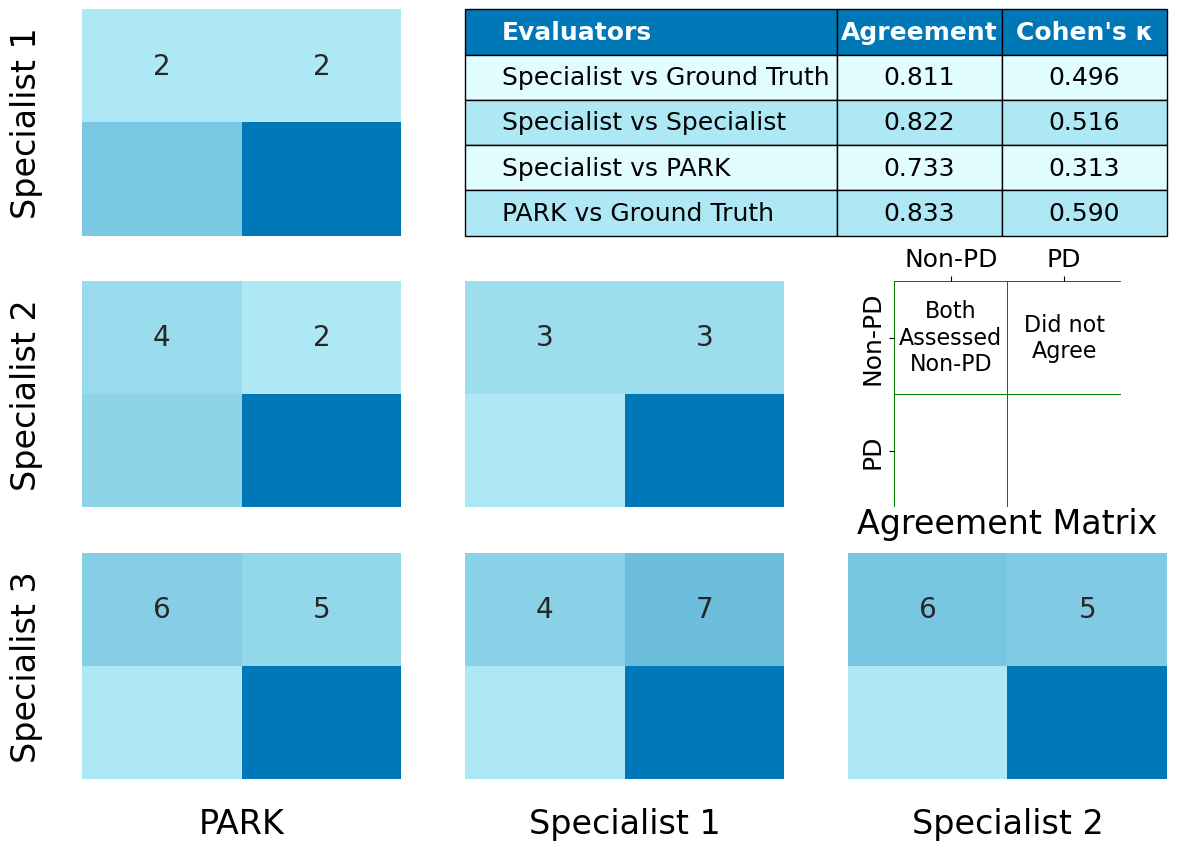

In [9]:
# --- Plotting ---

fig = plt.figure(figsize=(14, 10))
gs = fig.add_gridspec(3, 3)  # 3 rows, 6 columns

highlight_cells = [(0, 0), (1, 1), (2, 2)]
conf_matrix_axes = []
for i in range(3):
    row_axes = []
    for j in range(3):
        subplot = fig.add_subplot(gs[i, j])

        # subplot.axis('off')  # hide ticks/labels
        # subplot.spines['top'].set_visible(True)
        # subplot.spines['left'].set_visible(True)
        # subplot.spines['left'].set_edgecolor('red')

        row_axes.append(subplot)
    conf_matrix_axes.append(row_axes)

for i in range(3):
    for j in range(3):
        conf_matrix_axes[i][j].axis('off')

for i in range(1, 4):
    for j in range(i):
        y_true = predictions[entities[i]]
        y_pred = predictions[entities[j]]
        ax = conf_matrix_axes[i - 1][j]
        ax.axis('on')
        plot_conf_matrix(ax, y_true, y_pred)

for i in range(3):
    conf_matrix_axes[i][0].set_ylabel(entities[i + 1], rotation=90, labelpad=40, fontsize=24, va='center')

for j in range(3):
    conf_matrix_axes[2][j].set_xlabel(entities[j], fontsize=24, labelpad=20)

#table_ax = fig.add_subplot(gs[1:2, 2:])
table_ax = fig.add_subplot(gs[0:1, 1:3])
table_ax.axis('off')

table = table_ax.table(cellText=[["Evaluators", "Agreement", "Cohen's κ"]] + 
                      [[f"{row[0]}", f"{row[1]:.3f}", f"{row[2]:.3f}"] for row in table_data],
                      loc='center',
                      cellLoc='center',
                      colWidths=[0.45, 0.2, 0.2],
                      bbox=[0, 0, 1, 1]) 

for (i, j), cell in table.get_celld().items():
    if j == 0:  # First column
        cell.set_text_props(ha='left', x=0.01)  
    if i == 0:  # Header row
        cell.set_facecolor('#0077b6')  # Blue header
        cell.set_text_props(color='white', weight='bold')

for i in range(1, len(table_data) + 1):
    if i % 2 == 0:  # Even rows
        for j in range(3):
            table.get_celld()[(i, j)].set_facecolor('#ade8f4')  # Light blue
    else:  # Odd rows
        for j in range(3):
            table.get_celld()[(i, j)].set_facecolor('#e2fdff')  # Lighter blue

table.auto_set_font_size(False)
table.set_fontsize(18)
table.scale(1, 2) 


# Legend confusion matrix
legend_ax = fig.add_subplot(gs[1,2])  
legend_ax.axis('on') 
legend_ax.set_xticks([0, 1])
legend_ax.set_yticks([0, 1])
legend_ax.set_xticklabels(['Pred 0', 'Pred 1'])
legend_ax.set_yticklabels(['True 0', 'True 1'])
legend_ax.xaxis.set_ticks_position('top')
legend_ax.xaxis.set_label_position('top')

#legend_cm = np.array([[50, 10], [8, 32]])
legend_cm = np.array([[1, 0], [0, 1]])

sns.heatmap(
    legend_cm,
    annot=[['Both\nAssessed\nNon-PD', 'Did not\nAgree'], ['Did not\nAgree', 'Both\nAssessed\nPD']],
    fmt='',
    #cmap=['red','green'],
    cmap=['White'],
    # vmin=0.25,
    # vmax=0.75,
    cbar=False,
    linewidths=0.5,
    linecolor='green',
    square=True,
    ax=legend_ax,
    annot_kws={"size": 16, "weight": 'normal', "color": 'black'}
)

legend_ax.set_xlabel('')
legend_ax.set_ylabel('')
legend_ax.set_xticklabels(['Non-PD', 'PD'], fontsize=18)
legend_ax.set_yticklabels(['Non-PD', 'PD'], fontsize=18)
legend_ax.set_title('Agreement Matrix', fontsize=24, y=-0.15)


#plt.tight_layout()
plt.savefig("plots/figure_3/clinician_agreement.png", dpi=600, bbox_inches='tight')

### Fig 5a | Accuracy of PARK Compared to Accuracy of Task-Specific Models

subsets: {'100': 21, '010': 24, '001': 17, '110': 56, '101': 31, '011': 28, '111': 132, '000': 11}


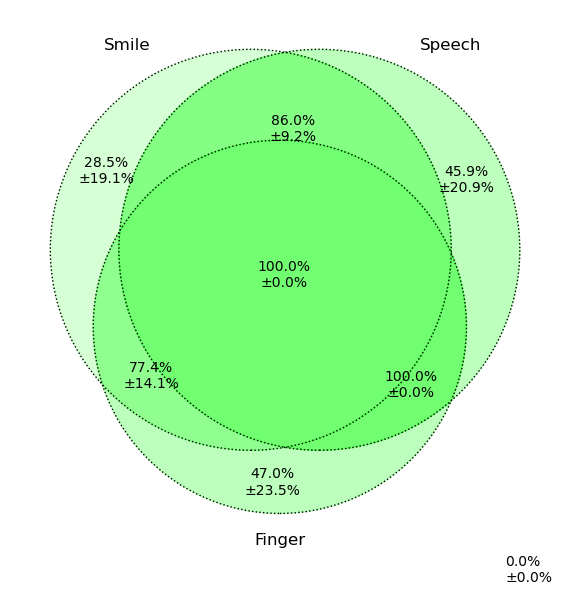

In [10]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib_venn import venn3, venn3_circles

df = pd.read_csv('../../data/test_data_big.csv')

correct_smile = ~df['misclassified_smile']
correct_speech = ~df['misclassified_speech']
correct_finger = ~df['misclassified_finger']
correct_fusion = ~df['misclassified_fusion']

masks = {
    '100': correct_smile & ~correct_speech & ~correct_finger,
    '010': ~correct_smile & correct_speech & ~correct_finger,
    '001': ~correct_smile & ~correct_speech & correct_finger,
    '110': correct_smile & correct_speech & ~correct_finger,
    '101': correct_smile & ~correct_speech & correct_finger,
    '011': ~correct_smile & correct_speech & correct_finger,
    '111': correct_smile & correct_speech & correct_finger,
    '000': ~correct_smile & ~correct_speech & ~correct_finger 
}


# correct samples per region
subsets = {k: v.sum() for k, v in masks.items()}

def bootstrap_metrics(y_correct, b=1000):
    n = len(y_correct)
    metrics = {"accuracy": []}
    
    for _ in range(b):
        idxs = np.random.choice(n, n, replace=True)
        
        y_correct_sample = y_correct.iloc[idxs]
        acc = np.mean(y_correct_sample)
        metrics["accuracy"].append(acc)
    
    results = {}
    for key in metrics.keys():
        mean = np.mean(metrics[key])
        std = np.std(metrics[key])
        ci = 1.96 * std  
        results[key] = (mean, ci)
    
    return results


fusion_results = {}
for key, mask in masks.items():
    results = bootstrap_metrics(~df.loc[mask, 'misclassified_fusion'])
    if mask.sum() > 0:
        fusion_results[key] = results['accuracy']
    else:
        fusion_results[key] = (np.nan, np.nan)

def accuracy_to_color(acc):
    if np.isnan(acc):
        return (0.9, 1.0, 0.9)  # very light green for NaN
    intensity = 1.0 - 0.7 * acc
    return (intensity, 1.0, intensity)

print(f'subsets: {subsets}')
plt.figure(figsize=(6,6))  
v = venn3(subsets=(subsets['100'], subsets['010'], subsets['110'],
                   subsets['001'], subsets['101'], subsets['011'],
                   subsets['111']),
          set_labels=('Smile', 'Speech', 'Finger'))

c = venn3_circles(subsets=(subsets['100'], subsets['010'], subsets['110'],
                            subsets['001'], subsets['101'], subsets['011'],
                            subsets['111']), linestyle='dotted')

for circle in c:
    circle.set_lw(1)

for region_id in ['100', '010', '110', '001', '101', '011', '111']:
    patch = v.get_patch_by_id(region_id)
    if patch:
        acc = fusion_results[region_id][0]
        patch.set_color(accuracy_to_color(acc))
        patch.set_alpha(0.8)

for region_id in ['100', '010', '110', '001', '101', '011', '111']:
    label = v.get_label_by_id(region_id)
    if label:
        acc, ci = fusion_results[region_id]
        if not np.isnan(acc):
            label.set_text(f'{acc*100:.1f}%\n±{ci*100:.1f}%')
        else:
            label.set_text('')

acc, ci = fusion_results['000']
outside_text = f'{acc*100:.1f}%\n±{ci*100:.1f}%' if not np.isnan(acc) else 'No Data'
plt.annotate(outside_text, xy=(0.9, -0.05), xycoords='axes fraction')

plt.tight_layout()
plt.show()
